<a href="https://colab.research.google.com/github/RobertArbon/art_of_md/blob/master/style_transfer_looped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# %tensorflow_version 1.x

In [2]:
import warnings

In [35]:
# Imports

import numpy as np

# we're using, deliberately, tensorflow 1.15 which throws a lot of FutureWarnings when imported. 
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    import tensorflow as tf

from lucid.modelzoo import vision_models
from lucid.misc.io import show, load, save
from lucid.misc.tfutil import create_session
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
from lucid.optvis.objectives import wrap_objective
import lucid.modelzoo.nets_factory as nets
from os.path import basename
from itertools import product
import pickle
from django.utils.text import get_valid_filename
from os.path import join
import re

Globals

In [5]:
# these constants help remember which image is at which batch dimension
TRANSFER_INDEX = 0
CONTENT_INDEX = 1
STYLE_INDEX = 2


SSH into BC4 and then list all the files (ordered by time) in a given directory. Pipe this into a local file

In [26]:
!ssh ra15808@bc4login.acrc.bris.ac.uk ls -t /mnt/storage/home/ra15808/scratch/art_of_md/bacon > file_list.txt

Read these files in and strip off any newline/whitespace characters: 

In [29]:
with open('file_list.txt') as f:
    file_list = f.readlines()
    file_list = [x.strip() for x in file_list]

`file_list` now gives you all the files on the remote directory, last created first. 

In [36]:
file_list = [x for x in file_list if re.search('W1\.00\.p', x)]

In [45]:
[(i, x) for i, x in enumerate(file_list)]

[(0,
  'VGG16_caffe_3_innocent-cropped_conv5_3conv5_3_W100.00_conv5_3conv5_3_W1.00.p'),
 (1,
  'VGG16_caffe_3_innocent-cropped_conv5_3conv5_3_W100.00_conv5_2conv5_2_W1.00.p'),
 (2,
  'VGG16_caffe_3_innocent-cropped_conv5_3conv5_3_W100.00_conv5_1conv5_1_W1.00.p'),
 (3,
  'VGG16_caffe_3_innocent-cropped_conv5_3conv5_3_W100.00_conv4_3conv4_3_W1.00.p'),
 (4,
  'VGG16_caffe_3_innocent-cropped_conv5_3conv5_3_W100.00_conv4_2conv4_2_W1.00.p'),
 (5,
  'VGG16_caffe_3_innocent-cropped_conv5_3conv5_3_W100.00_conv4_1conv4_1_W1.00.p'),
 (6,
  'VGG16_caffe_3_innocent-cropped_conv5_3conv5_3_W100.00_conv3_3conv3_3_W1.00.p'),
 (7,
  'VGG16_caffe_3_innocent-cropped_conv5_3conv5_3_W100.00_conv3_2conv3_2_W1.00.p'),
 (8,
  'VGG16_caffe_3_innocent-cropped_conv5_3conv5_3_W100.00_conv3_1conv3_1_W1.00.p'),
 (9,
  'VGG16_caffe_3_innocent-cropped_conv5_3conv5_3_W100.00_conv2_2conv2_2_W1.00.p'),
 (10,
  'VGG16_caffe_3_innocent-cropped_conv5_3conv5_3_W100.00_conv2_1conv2_1_W1.00.p'),
 (11,
  'VGG16_caffe_3_innocent

Now grab them using scp and put them somewhere convenient. The braces allow you to use python variables in the bash command

VGG16_caffe_3_innocent-cropped_conv4_1conv4_1_W100.00_conv4_1conv4_1_W1.00.p
VGG16_caffe_3_innocent-cropped_conv4_1conv4_1 100%   18MB 991.7KB/s   00:18    



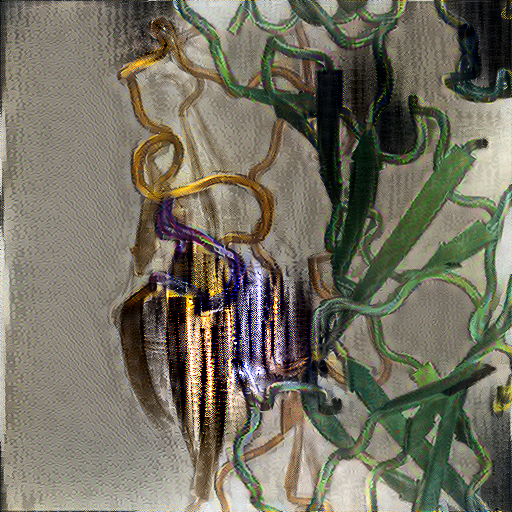
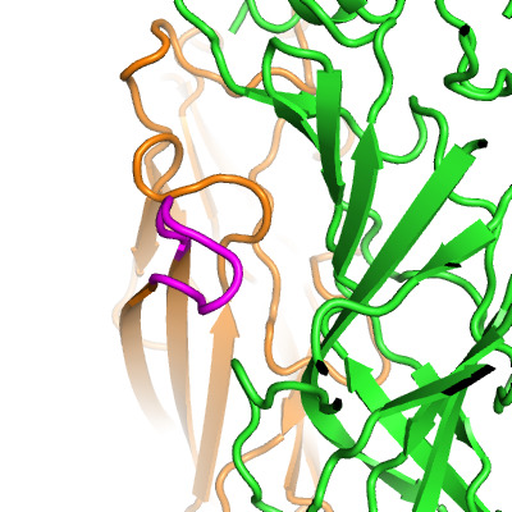
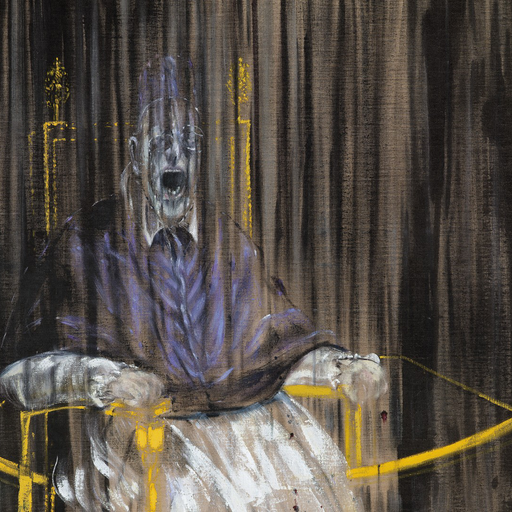

In [49]:
ix = 70
print(file_list[ix])

!scp ra15808@bc4login.acrc.bris.ac.uk:/mnt/storage/home/ra15808/scratch/art_of_md/bacon/{file_list[ix]} images/bacon

result = pickle.load(open(join('images', 'bacon',file_list[ix]), 'rb'))

show(result['image'][-1])

Arguments

In [0]:
max_layers = 5
style_min = 0.01
style_max = 0.2
style_grid_n = 5
model_name = 'VGG16_caffe'
content_weight=100
max_dim = 512


content_path = "3.jpg"
content_name = basename(content_path).split('.')[0]
style_path = "innocent-cropped.jpg"
style_name = basename(style_path).split('.')[0]

Get model

In [0]:
model = nets.models_map[model_name]()
model.load_graphdef()


Param grid

In [0]:
style_weights = np.logspace(np.log10(style_min), np.log10(style_max), style_grid_n)
style_weights *= content_weight
layers = [x.name for x in model.layers if 'conv' in x.tags]
stride = int(np.floor(len(layers)/max_layers))
layers = layers[::stride]
params = list(product(style_weights, layers, layers))


In [0]:
assert tf.test.is_gpu_available(), 'No GPU!'

In [0]:
def load_img(path_to_img, max_dim=512):
  from PIL import Image
  img = Image.open(path_to_img)
  long = min(img.size)
  scale = max_dim/long
  img = np.asarray(img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), 
                   Image.ANTIALIAS))
  img_max = np.iinfo(img.dtype).max
  npimg = np.divide(img, img_max, dtype=np.float32)
  return npimg

def style_transfer_param(content_image, style_image, decorrelate=True, fft=True):
  style_transfer_input = param.image(*content_image.shape[:2], decorrelate=decorrelate, fft=fft)[0]
  content_input = content_image
  style_input = tf.random_crop(style_image, content_image.shape)
  return tf.stack([style_transfer_input, content_input, style_input])

def mean_L1(a, b):
  return tf.reduce_mean(tf.abs(a-b))

@wrap_objective
def activation_difference(layer_names, activation_loss_f=mean_L1, transform_f=None, difference_to=CONTENT_INDEX):
  def inner(T):
    # first we collect the (constant) activations of image we're computing the difference to
    image_activations = [T(layer_name)[difference_to] for layer_name in layer_names]
    if transform_f is not None:
      image_activations = [transform_f(act) for act in image_activations]
    
    # we also set get the activations of the optimized image which will change during optimization
    optimization_activations = [T(layer)[TRANSFER_INDEX] for layer in layer_names]
    if transform_f is not None:
      optimization_activations = [transform_f(act) for act in optimization_activations]
    
    # we use the supplied loss function to compute the actual losses
    losses = [activation_loss_f(a, b) for a, b in zip(image_activations, optimization_activations)]
    return tf.add_n(losses) 
    
  return inner

def gram_matrix(array, normalize_magnitue=True):
  channels = tf.shape(array)[-1]
  array_flat = tf.reshape(array, [-1, channels])
  gram_matrix = tf.matmul(array_flat, array_flat, transpose_a=True)
  if normalize_magnitue:
    length = tf.shape(array_flat)[0]
    gram_matrix /= tf.cast(length, tf.float32)
  return gram_matrix


In [0]:
content_image = load_img(content_path, max_dim=max_dim)
style_image = load_img(style_path, max_dim=max_dim) 
param_f = lambda: style_transfer_param(content_image, style_image)
for i in range(len(params[:3])):
  # get params
  style_weight = params[i][0]
  content_layers = [params[i][1]]
  style_layers = [params[i][2]]

  # set up objective functions
  content_obj = content_weight * activation_difference(content_layers, difference_to=CONTENT_INDEX)
  content_obj.description = "Content Loss"
  style_obj = style_weight*activation_difference(style_layers, transform_f=gram_matrix, difference_to=STYLE_INDEX)
  style_obj.description = "Style Loss"
  objective = - content_obj - style_obj

  # do learning
  vis = render.render_vis(model, objective, param_f=param_f, thresholds=[128, 256], verbose=False)
  
  # package results
  results = {'style_layers': style_layers, 'content_layers': content_layers, 
           'style_weight': style_weight, 'content_weight': content_weight, 
           'model': model_name, 'image': np.array(vis), 
            'style_name': style_name, 'content_name': content_name}

  # save results
  fname = '{0}_{1}_{2}_{3}_W{4:4.2f}_{5}_W{6:4.2f}.p'.format(results['model'], 
                                                           results['content_name'], 
                                                          results['style_name'], 
                                                          results['content_layers'], 
                                                          results['content_weight'], 
                                                          results['style_layers'], 
                                                          results['style_weight'])
  fname = get_valid_filename(fname)
  pickle.dump(obj=results, file=open(fname, 'wb'))

